<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
    <b style="font-size: 35px">خوشه‌بندی</b><br>
</font></div>

<div style="direction:rtl;line-height:300%;"><font face="XB Zar" size=3>
در این سوال قصد داریم دو الگوریتم kmeans و GMM را پیاده‌سازی کنیم. برای پیاده‌سازی این دو الگوریتم از کتابخانه‌های آماده پایتون که این دو الگوریتم در آن‌ها پیاده‌سازی شده‌اند استفاده نکنید. از این پیاده‌سازی در حل سوال‌های زیر استفاده کنید.

الگوریتم kmeans تا زمانی ادامه یابد که مرکز خوشه‌ها تغییر نکند و GMM نیز تا زمانی که اختلاف دو لگاریتم likelihood متوالی کمتر از 0.1 شود، ادامه یابد و مراکز اولیه GMM را مراکزی درنظر بگیرید که پس از اجرای الگوریتم kmeans به دست می‌آورید.
</font>
</div>

In [9]:
# kmeans
class K_Means:
    def __init__(self, k):
        self.k = k


    def fit(self,data, initial_points):

        self.centroids = initial_points

        optimized = False
        while optimized == False:
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            self.y_hat = []
            # assigning datapoints to clusters
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.y_hat.append(classification)
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            # updating centroids
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            cnt = 0
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum(current_centroid == original_centroid):
                    cnt += 1
                if cnt == self.k:
                    optimized = True

            if optimized:
                break

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
import math
class GMM:
    def __init__(self, k, initial_points):
        self.k = k
        

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape
        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)

        self.mu = initial_points
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]
        self.prev_llh = 0
        self.curr_llh = 0

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        cnt = 0
        
        while True:
            self.e_step(X)
            self.m_step(X)
            if np.abs(self.curr_llh-self.prev_llh) < 0.1:
#                 print(self.curr_llh-self.prev_llh)
#                 print(cnt)
                break
            cnt += 1
    
    def calc_loglikelihood(residuals):
        return -0.5 * (np.log(np.linalg.det(cov)) + residuals.T.dot(np.linalg.inv(cov)).dot(residuals) + 2 * np.log(2 * np.pi))

            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k))
        loglikelihood = 0
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
            loglikelihood += multivariate_normal.logpdf(X, mean=self.mu[i], cov=self.sigma[i])
        loglikelihoodsum = loglikelihood.sum()
        self.prev_llh = self.curr_llh
        self.curr_llh = loglikelihoodsum
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
الف:
با استفاده از تابع زیر دیتاست را ایجاد کنید سپس با تعداد k=2 دو الگوریتم را روی دیتاست اجرا کنید. در روش k-means بهتر است الگوریتم را چندین بار با حالت های شروع مختلف اجرا کرده و بهترین نتیجه را انتخاب کنید.
    </font>
</div>

In [11]:
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
# purity
def purity(y, y_hat):
    contingency_matrix = metrics.cluster.contingency_matrix(y, y_hat)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
# rand-index
def adjusted_rand_index(y, y_hat) -> float:
    return adjusted_rand_score(y, y_hat)

In [12]:
from sklearn.datasets.samples_generator import make_classification
import matplotlib.pyplot as plt

X,Y = make_classification(n_samples=700, n_features=10,
                           n_informative=5, n_redundant=0,
                           n_clusters_per_class=2, n_classes=3)

In [14]:
import random
# running k-means
k = 2
best_start_point = 0
best_kmeans_model = None
for dif_start_points in range(50):
    kmean = K_Means(k)
    initial_indexes = random.sample(range(0, len(X)), k)
    initial_points = {}
    for i in range(len(initial_indexes)):
        initial_points[i] = X[initial_indexes[i]]
    kmean.fit(X, initial_points)
    metr = purity(Y, kmean.y_hat) + adjusted_rand_index(Y, kmean.y_hat)
    if metr > best_start_point:
        best_start_point = metr
        best_kmeans_model = kmean
print("purity of k-means model: " + str(purity(Y, best_kmeans_model.y_hat)))
print("rand-index of k-means model: " + str(adjusted_rand_index(Y, best_kmeans_model.y_hat)))

# running GMMs
np.random.seed(42)
gmm = GMM(k, best_kmeans_model.centroids)
gmm.fit(X)
y_hat = gmm.predict(X)
print("purity of GMM model: " + str(purity(Y, y_hat)))
print("rand-index of GMM model: " + str(adjusted_rand_index(Y, y_hat)))

purity of k-means model: 0.5442857142857143
rand-index of k-means model: 0.17425987995055695
purity of GMM model: 0.4828571428571429
rand-index of GMM model: 0.09567848949095954


<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ب:
        کیفیت الگوریتم‌های خوشه بندی پیاده سازی شده را با استفاده از روشهای Purity و Index - Rand بدست آورید و آنها را با هم مقایسه کنید.
        
        پاسخ) purity الگوریتم kmeans کمی از GMM بهتر شده است که این یعنی در هر دسته تعداد داده‌های بیشتری وجود داشتند که لیبل یکسانی داشتند.
        rand-index هم برای kmeans بهتر است و این یعنی داده‌های دو دسته با هم تفاوت بیشتری دارند. 
    </font>
</div>

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ج:
        با استفاده از دستورات زیر دیتاست‌های جدید ایجاد کنید و دو الگوریتم را روی آن‌ها اجرا کنید و پس از بصری‌سازی با استفاده از کتابخانه‌های آماده پایتون، نتایج خوشه‌بندی را مقایسه کنید. 

از هر کتابخانه بصری‌سازی پایتون می‌توانید استفاده کنید. تعداد خوشه‌ها را برابر ۲ بگیرید.
    </font>
</div>

In [15]:
from sklearn.datasets.samples_generator import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

In [16]:
# running k-means
k = 2
best_start_point = 0
best_kmeans_model = None
for dif_start_points in range(50):
    kmean = K_Means(k)
    initial_indexes = random.sample(range(0, len(X)), k)
    initial_points = {}
    for i in range(len(initial_indexes)):
        initial_points[i] = X[initial_indexes[i]]
    kmean.fit(X, initial_points)
    metr = purity(Y, kmean.y_hat) + adjusted_rand_index(Y, kmean.y_hat)
    if metr > best_start_point:
        best_start_point = metr
        best_kmeans_model = kmean
print("purity of k-means model: " + str(purity(Y, best_kmeans_model.y_hat)))
print("rand-index of k-means model: " + str(adjusted_rand_index(Y, best_kmeans_model.y_hat)))

# running GMMs
np.random.seed(42)
gmm = GMM(k, best_kmeans_model.centroids)
gmm.fit(X)
y_hat = gmm.predict(X)
print("purity of GMM model: " + str(purity(Y, y_hat)))
print("rand-index of GMM model: " + str(adjusted_rand_index(Y, y_hat)))

purity of k-means model: 0.82
rand-index of k-means model: 0.40876642811778974
purity of GMM model: 0.7357142857142858
rand-index of GMM model: 0.2213560363037783


kmeans for first dataset


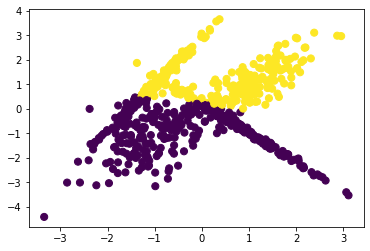

GMM for first dataset


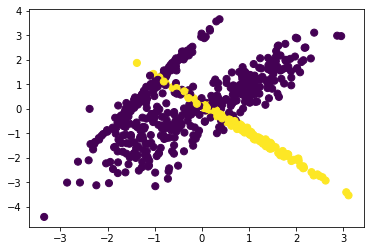

In [17]:
print("kmeans for first dataset")
plt.scatter(X[:, 0], X[:, 1], c=best_kmeans_model.y_hat, s=50, cmap='viridis')
plt.show()
print("GMM for first dataset")
plt.scatter(X[:, 0], X[:, 1], c=y_hat, s=50, cmap='viridis')

In [18]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

In [19]:
# running k-means
k = 2
best_start_point = 0
best_kmeans_model = None
for dif_start_points in range(50):
    kmean = K_Means(k)
    initial_indexes = random.sample(range(0, len(X)), k)
    initial_points = {}
    for i in range(len(initial_indexes)):
        initial_points[i] = X[initial_indexes[i]]
    kmean.fit(X, initial_points)
    metr = purity(Y, kmean.y_hat) + adjusted_rand_index(Y, kmean.y_hat)
    if metr > best_start_point:
        best_start_point = metr
        best_kmeans_model = kmean
print("purity of k-means model: " + str(purity(Y, best_kmeans_model.y_hat)))
print("rand-index of k-means model: " + str(adjusted_rand_index(Y, best_kmeans_model.y_hat)))

# running GMMs
np.random.seed(42)
gmm = GMM(k, best_kmeans_model.centroids)
gmm.fit(X)
y_hat = gmm.predict(X)
print("purity of GMM model: " + str(purity(Y, y_hat)))
print("rand-index of GMM model: " + str(adjusted_rand_index(Y, y_hat)))

purity of k-means model: 0.7514285714285714
rand-index of k-means model: 0.251796172637286
purity of GMM model: 0.8228571428571428
rand-index of GMM model: 0.4161345900618564


kmeans for second dataset


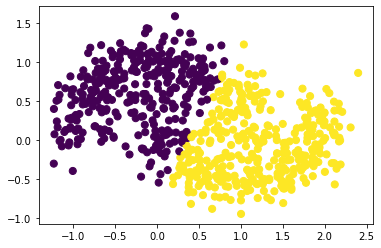

GMM for second dataset


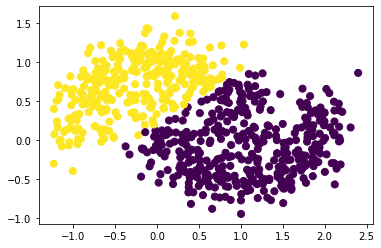

In [20]:
print("kmeans for second dataset")
plt.scatter(X[:, 0], X[:, 1], c=best_kmeans_model.y_hat, s=50, cmap='viridis')
plt.show()
print("GMM for second dataset")
plt.scatter(X[:, 0], X[:, 1], c=y_hat, s=50, cmap='viridis')
plt.show()

In [21]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

In [22]:
# running k-means
k = 2
best_start_point = 0
best_kmeans_model = None
for dif_start_points in range(50):
    kmean = K_Means(k)
    initial_indexes = random.sample(range(0, len(X)), k)
    initial_points = {}
    for i in range(len(initial_indexes)):
        initial_points[i] = X[initial_indexes[i]]
    kmean.fit(X, initial_points)
    metr = purity(Y, kmean.y_hat) + adjusted_rand_index(Y, kmean.y_hat)
    if metr > best_start_point:
        best_start_point = metr
        best_kmeans_model = kmean
print("purity of k-means model: " + str(purity(Y, best_kmeans_model.y_hat)))
print("rand-index of k-means model: " + str(adjusted_rand_index(Y, best_kmeans_model.y_hat)))

# running GMMs
np.random.seed(42)
gmm = GMM(k, best_kmeans_model.centroids)
gmm.fit(X)
y_hat = gmm.predict(X)
print("purity of GMM model: " + str(purity(Y, y_hat)))
print("rand-index of GMM model: " + str(adjusted_rand_index(Y, y_hat)))

purity of k-means model: 0.5142857142857142
rand-index of k-means model: -0.0006147474167486716
purity of GMM model: 0.5014285714285714
rand-index of GMM model: -0.0014202618242849195


kmeans for third dataset


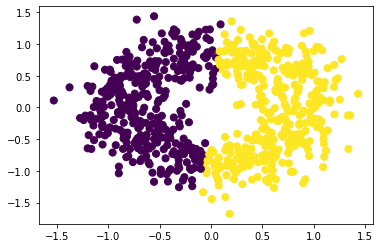

GMM for third dataset


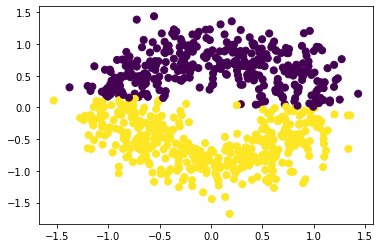

In [23]:
print("kmeans for third dataset")
plt.scatter(X[:, 0], X[:, 1], c=best_kmeans_model.y_hat, s=50, cmap='viridis')
plt.show()
print("GMM for third dataset")
plt.scatter(X[:, 0], X[:, 1], c=y_hat, s=50, cmap='viridis')

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
در مورد اول در شکل کاملا مشخص است که kmeans بهتر از GMM دسته بندی کرده است و جدا بودن دو دسته مشخص تر است.
        در سومی چندان فرقی بین دو دسته بند وجود ندارد و اعداد purity و rand-index هم همین موضوع را نشان می‌دهند.
        در دومی ولی GMM بهتر است چون اگر به شکل نگاه کنید تعدادی نقطه وجود دارند که outlier هستند و در قسمت زرد رنگ وجود دارند و به دلیل وجود این نقاط در الگوریتم kmeans مرکز  به سمت راست متمایل شده است و نتیجه‌ی purity بد شده است.
    </font>
</div>